In [1]:
import os
import sys

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import keras
import os
import tensorflow as tf

c:\Users\mt01034\Anaconda3\envs\tf-env\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\mt01034\Anaconda3\envs\tf-env\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
c:\Users\mt01034\Anaconda3\envs\tf-env\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [3]:
#!pip install -U efficientnet

In [4]:
#import efficientnet.keras as efn 

#model = efn.EfficientNetB5(weights='imagenet')  # or weights='noisy-student'

In [3]:
import cv2
import time

In [4]:
import scipy as sp
import numpy as np
import random as rn
import pandas as pd
from tqdm import tqdm
from PIL import Image
from functools import partial
import matplotlib.pyplot as plt

In [5]:
import tensorflow as tf
import keras

In [6]:
#DATA_DIR = 'data/'
TRAIN_LABEL_PATH = "train.csv"
TEST_LABEL_PATH = 'test.csv'
TRAIN_IMAGE_PATH =  "train_images/"
TEST_IMAGE_PATH =  'test_images/'

TRAINED_MODEL_NAME = 'retinorestnet_50.h5'

# Set seed for reproducability
seed = 1989
rn.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

In [7]:
print("Train Image IDs and Labels")
train_label = pd.read_csv(TRAIN_LABEL_PATH)
# Add extension to id_code
train_label['id_code'] = train_label['id_code'] + ".jpg"
print(f"Training images: {train_label.shape[0]}")
display(train_label.head())

#print("TEST Image IDs")
#test_label = pd.read_csv(TEST_LABEL_PATH)
# Add extension to id_code
#test_label['image'] = test_label['image'] + ".jpg"
#print(f"Testing Images: {test_label.shape[0]}")
#display(test_label.head())

Train Image IDs and Labels
Training images: 3662


,id_code,diagnosis,diagnosis_binary
0,000c1434d8d7.jpg,2,1
1,001639a390f0.jpg,4,1
2,0024cdab0c1e.jpg,1,1
3,002c21358ce6.jpg,0,0
4,005b95c28852.jpg,0,0


In [8]:
# Specify image size
IMAGE_WIDTH = 512
IMAGE_HEIGHT = 512
CHANNELS = 3

In [10]:
from keras import initializers
from keras import regularizers
from keras import constraints
from keras import backend as K
from keras.activations import elu
from keras.optimizers import adam_v2
from keras.models import Sequential
#from keras.engine import Layer, InputSpec
from keras.utils.generic_utils import get_custom_objects
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Conv2D, Flatten, GlobalAveragePooling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import cohen_kappa_score

In [11]:
def get_predictions_and_labels(model, generator):
    predictions = []
    labels = []
    for k in range(int(np.ceil(generator.samples / BATCH_SIZE))):
        x, y = next(generator)
        predictions.append(model.predict(x))
        labels.append(y)
    # Flatten list of numpy arrays
    return np.concatenate(predictions).ravel(), np.concatenate(labels).ravel()

In [13]:
class Metrics(Callback):
   
    def on_train_begin(self, logs={}):
        
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        
        # Get predictions and convert to integers
        y_prediction, labels = get_predictions_and_labels(model, val_generator)
        y_prediction = np.rint(y_prediction).astype(np.uint8).clip(0, 4)
        # We can use sklearns implementation of QWK straight out of the box
        # as long as we specify weights as 'quadratic'
        _val_kappa = cohen_kappa_score(labels, y_prediction, weights='quadratic')
        self.val_kappas.append(_val_kappa)
        print(f"val_kappa: {round(_val_kappa, 4)}")
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save(TRAINED_MODEL_NAME)
        return

In [15]:
train_label['id_code'].value_counts()

000c1434d8d7.jpg    1
a963ac561580.jpg    1
a987aa7aac37.jpg    1
a9a28c37c8c4.jpg    1
a9a3225cf4b5.jpg    1
                   ..
54b322c66d01.jpg    1
54bbe3da103e.jpg    1
54bdcdecd8f3.jpg    1
54cab3596214.jpg    1
ffec9a18a3ce.jpg    1
Name: id_code, Length: 3662, dtype: int64

Text(0, 0.5, 'No. of Images')

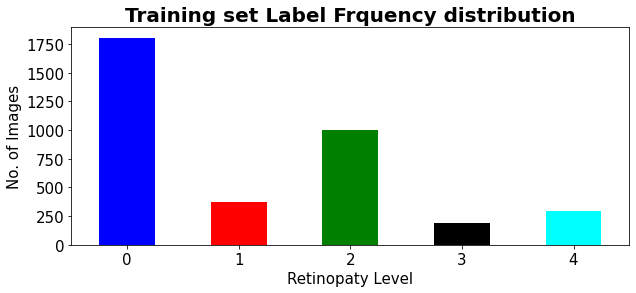

In [17]:
# Label distribution
train_label['diagnosis'].value_counts().sort_index().plot(kind="bar", figsize=(10,4), rot=0, color=['blue', 'red', 'green', 'black', 'cyan'])
plt.title("Training set Label Frquency distribution",weight='bold', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Retinopaty Level", fontsize=15)
plt.ylabel("No. of Images", fontsize=15)


In [18]:
Sampleimagelist=[]

train_images/44a86263117b.jpg


TypeError: Image data of dtype object cannot be converted to float

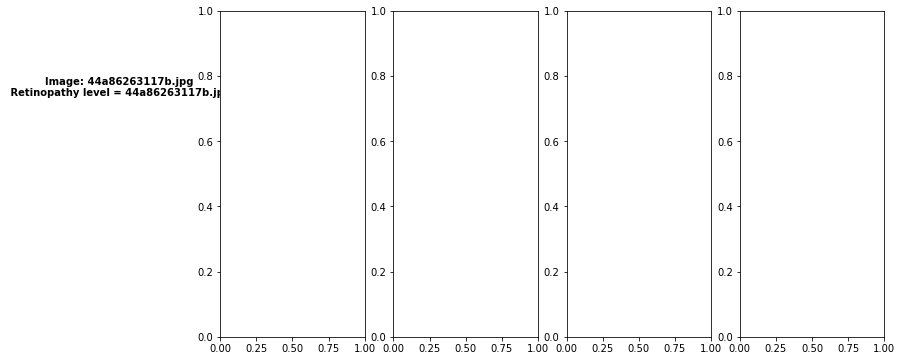

In [21]:
# Example from every label
fig, ax = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):
    sample_image = train_label[train_label['diagnosis'] == i].sample(1)
    image_name = sample_image['id_code'].item()
    #print (image_name)
    Sampleimagelist.append(image_name)
    IMG = cv2.imread(f"{TRAIN_IMAGE_PATH}{image_name}")
    ax[i].set_title(f"Image: {image_name}\n Retinopathy level = {sample_image['id_code'].item()}", weight='bold', fontsize=10)
    ax[i].axis('off')
    print (f"{TRAIN_IMAGE_PATH}{image_name}")
    ax[i].imshow(IMG);

In [ ]:
def crop_image_from_gray(image, tolerance=8):
    if image.ndim == 2:
        mask = image > tolerance
        return image[np.ix_(mask.any(1),mask.any(0))]
    # If we have a normal RGB images
    elif image.ndim == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        mask = gray_image > tolerance
        
        check_shape = image[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return image # return original image
        else:
            img1=image[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=image[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=image[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            image = np.stack([img1,img2,img3],axis=-1)
        return image



In [ ]:
def preprocess_image(image, sigmaX=10):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    image = cv2.addWeighted (image,4, cv2.GaussianBlur(image, (0,0) ,sigmaX), -4, 128)
    return image

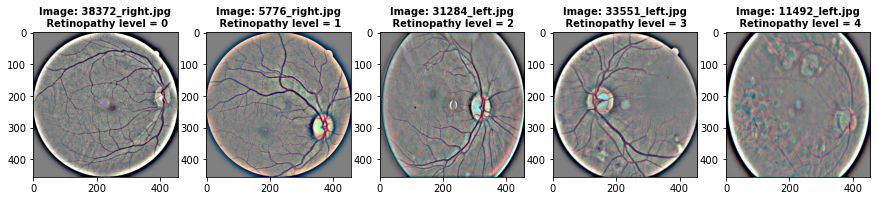

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(15, 6))
for i, image_name in enumerate(Sampleimagelist):
    X = preprocess_image(cv2.imread(f"{TRAIN_IMAGE_PATH}{image_name}"))
    ax[i].set_title(f"Image: {image_name}\n Retinopathy level = {i}", weight='bold', fontsize=10)
    #ax[i].axis('off')
    ax[i].imshow(X);
    

In [ ]:
# Labels for training data
y_labels = train_label['level'].values

In [ ]:
# We use a small batch size so we can handle large images easily
BATCH_SIZE = 8

In [ ]:
# Add Image augmentation to our generator
train_datagen = ImageDataGenerator(rotation_range=360,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split=0.20,
                                   preprocessing_function=preprocess_image, 
                                   rescale=1 / 128.)


In [ ]:
# Use the dataframe to define train and validation generators
train_generator = train_datagen.flow_from_dataframe(train_label, 
                                                    x_col='image', 
                                                    y_col='level',
                                                    directory = TRAIN_IMAGE_PATH,
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='other', 
                                                    subset='training')

Found 28101 validated image filenames.


In [ ]:
val_generator = train_datagen.flow_from_dataframe(train_label, 
                                                  x_col='image', 
                                                  y_col='level',
                                                  directory = TRAIN_IMAGE_PATH,
                                                  target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='other',
                                                  subset='validation')

Found 7025 validated image filenames.


In [ ]:
class GroupNormalization(Layer):
  
    def __init__(self,
                 groups=32,
                 axis=-1,
                 epsilon=1e-5,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(GroupNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.groups = groups
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        dim = input_shape[self.axis]

        if dim is None:
            raise ValueError('Axis ' + str(self.axis) + ' of '
                             'input tensor should have a defined dimension '
                             'but the layer received an input with shape ' +
                             str(input_shape) + '.')

        if dim < self.groups:
            raise ValueError('Number of groups (' + str(self.groups) + ') cannot be '
                             'more than the number of channels (' +
                             str(dim) + ').')

        if dim % self.groups != 0:
            raise ValueError('Number of groups (' + str(self.groups) + ') must be a '
                             'multiple of the number of channels (' +
                             str(dim) + ').')

        self.input_spec = InputSpec(ndim=len(input_shape),
                                    axes={self.axis: dim})
        shape = (dim,)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.built = True

    def call(self, inputs, **kwargs):
        input_shape = K.int_shape(inputs)
        tensor_input_shape = K.shape(inputs)

        # Prepare broadcasting shape.
        reduction_axes = list(range(len(input_shape)))
        del reduction_axes[self.axis]
        broadcast_shape = [1] * len(input_shape)
        broadcast_shape[self.axis] = input_shape[self.axis] // self.groups
        broadcast_shape.insert(1, self.groups)

        reshape_group_shape = K.shape(inputs)
        group_axes = [reshape_group_shape[i] for i in range(len(input_shape))]
        group_axes[self.axis] = input_shape[self.axis] // self.groups
        group_axes.insert(1, self.groups)

        # reshape inputs to new group shape
        group_shape = [group_axes[0], self.groups] + group_axes[2:]
        group_shape = K.stack(group_shape)
        inputs = K.reshape(inputs, group_shape)

        group_reduction_axes = list(range(len(group_axes)))
        group_reduction_axes = group_reduction_axes[2:]

        mean = K.mean(inputs, axis=group_reduction_axes, keepdims=True)
        variance = K.var(inputs, axis=group_reduction_axes, keepdims=True)

        inputs = (inputs - mean) / (K.sqrt(variance + self.epsilon))

        # prepare broadcast shape
        inputs = K.reshape(inputs, group_shape)
        outputs = inputs

        # In this case we must explicitly broadcast all parameters.
        if self.scale:
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            outputs = outputs * broadcast_gamma

        if self.center:
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            outputs = outputs + broadcast_beta

        outputs = K.reshape(outputs, tensor_input_shape)

        return outputs

    def get_config(self):
        config = {
            'groups': self.groups,
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(GroupNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

In [ ]:
import efficientnet.keras as efn 


# Load in EfficientNetB5
efnmodel = efn.EfficientNetB5(weights='imagenet',
                        include_top=False,
                        input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS))

In [ ]:
# Replace all Batch Normalization layers by Group Normalization layers
for i, layer in enumerate(efnmodel.layers):
    if "batch_normalization" in layer.name:
        efnmodel.layers[i] = GroupNormalization(groups=32, axis=-1, epsilon=0.00001)

In [ ]:
def build_model():
    """
    A custom implementation of EfficientNetB5 (Regression)
    """
    model = Sequential()
    model.add(efnmodel)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(5, activation=elu))
    model.add(Dense(1, activation="linear"))
    model.compile(loss='mse', optimizer='Adam', metrics=['mse', 'acc'])
    print(model.summary())
    return model


In [ ]:
# Initialize model
model = build_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Model)      (None, 15, 15, 2048)      28513520  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 28,523,771
Trainable params: 28,351,035
Non-trainable params: 172,736
_________________________________________________________________
None


In [ ]:
# For tracking Quadratic Weighted Kappa score
kappa_metrics = Metrics()

In [ ]:
# Monitor MSE to avoid overfitting and save best model
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=12)
rlr = ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.5, 
                        patience=4, 
                        verbose=1, 
                        mode='auto', 
                        min_delta=0.0001)

In [ ]:
# Begin training
model.fit_generator(train_generator,
                    steps_per_epoch=train_generator.samples // BATCH_SIZE,
                    epochs=5,
                    validation_data=val_generator,
                    validation_steps = val_generator.samples // BATCH_SIZE,
                    callbacks=[kappa_metrics, es, rlr])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
7025/7025 [==============================] - ETA: 0s - loss: 0.9720 - mse: 0.9720 - acc: 0.2777val_kappa: 0.0078
Validation Kappa has improved. Saving model.
7025/7025 [==============================] - 3192s 454ms/step - loss: 0.9720 - mse: 0.9720 - acc: 0.2777 - val_loss: 0.9194 - val_mse: 0.9194 - val_acc: 0.1347 - lr: 0.0010
Epoch 2/5
7025/7025 [==============================] - ETA: 0s - loss: 0.9622 - mse: 0.9622 - acc: 0.2704val_kappa: 0.1244
Validation Kappa has improved. Saving model.
7025/7025 [==============================] - 3179s 453ms/step - loss: 0.9622 - mse: 0.9622 - acc: 0.2704 - val_loss: 0.8927 - val_mse: 0.8927 - val_acc: 0.3586 - lr: 0.0010
Epoch 3/5
7025/7025 [==============================] - ETA: 0s - loss: 0.8737 - mse: 0.8737 - acc: 0.4723val_kappa: 0.3128
Validation Kappa has improved. Saving model.
7025/7025 [==============================] - 3173s 452ms/step - loss: 0.87

Text(0, 0.5, 'Loss (MSE)')

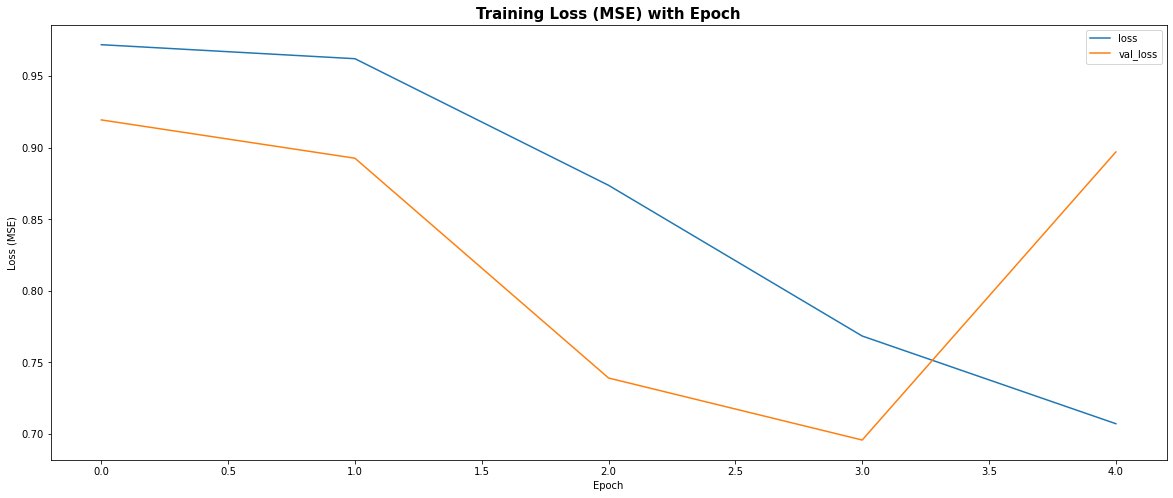

In [ ]:
history_df = pd.DataFrame(model.history.history)
history_df[['loss', 'val_loss']].plot(figsize=(20,8))
plt.title("Training Loss (MSE) with Epoch", fontsize=15, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")

Text(0, 0.5, 'Accuracy')

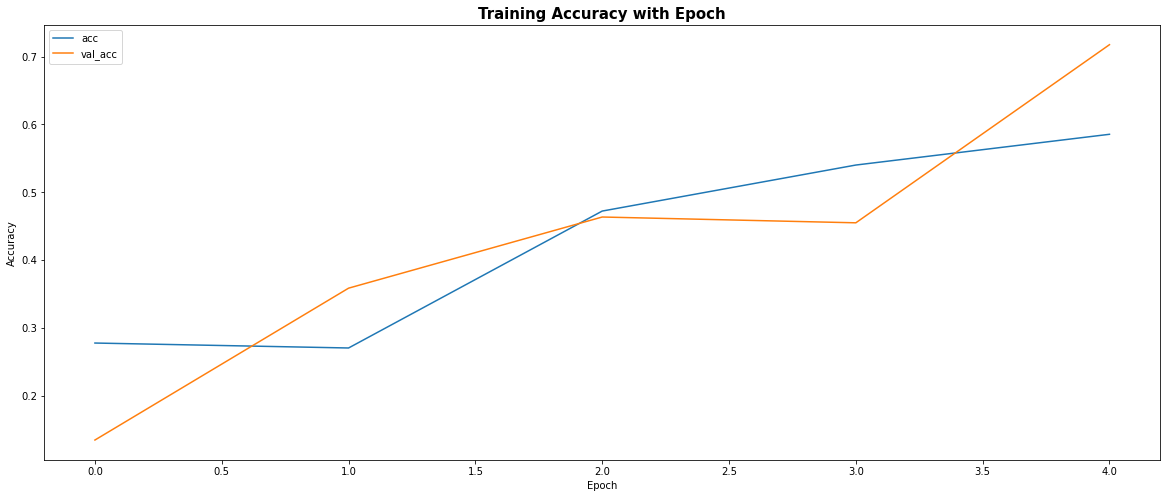

In [ ]:
history_df[['acc', 'val_acc']].plot(figsize=(20,8))
plt.title("Training Accuracy with Epoch", fontsize=15, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

In [ ]:
# Load best weights according to MSE
model.load_weights(TRAINED_MODEL_NAME)

In [ ]:
# Calculate QWK on train set
y_train_preds, train_labels = get_preds_and_labels(model, train_generator)
y_train_preds = np.rint(y_train_preds).astype(np.uint8).clip(0, 4)

# Calculate score
train_score = cohen_kappa_score(train_labels, y_train_preds, weights="quadratic")


In [ ]:
train_score

0.4408693646796884

In [ ]:
# Calculate QWK on validation set
y_val_preds, val_labels = get_preds_and_labels(model, val_generator)
y_val_preds = np.rint(y_val_preds).astype(np.uint8).clip(0, 4)

# Calculate score
val_score = cohen_kappa_score(val_labels, y_val_preds, weights="quadratic")

In [ ]:
val_score

0.4217138991931685